# TOF data
Data taken at intervals of $T=0.1ms$, where $T$ represents the period of free flight after trapping. Captured in sequences of 10 ranging from 0.1ms to 1.0ms. 

In [87]:
#Imports

#path tools
from pathlib import Path
import os

#image processing
from skimage.io import imread, imshow
from skimage.measure import label, regionprops
from scipy.ndimage import median_filter

#other utils
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats.contingency import margins #compute marginals
from scipy.optimize import curve_fit

wd = Path(os.getcwd()) #current working directory
np.seterr(divide='ignore'); #doesn't end up mattering, suppress the annoying warning

In [88]:
DATA_DIR = Path("../data/mar02/")

#count from .1 to 1.0 in intervals of 1 and then start over
time_data = list(zip(*product(range(10), np.arange(.1,1.1,.1))))[1]
data = []

In [89]:
for i,time in enumerate(time_data):
    print(i, time)
    data.append(
        DataRun(11+i, time)
    )

0 0.1


/tmp/ipykernel_267757/3816767937.py:45: RuntimeWarning: invalid value encountered in divide
  I_div_arr = np.divide(I_arr, I0_arr)


1 0.2
2 0.30000000000000004
3 0.4
4 0.5
5 0.6
6 0.7000000000000001
7 0.8
8 0.9
9 1.0
10 0.1
11 0.2
12 0.30000000000000004
13 0.4
14 0.5
15 0.6
16 0.7000000000000001
17 0.8
18 0.9
19 1.0
20 0.1
21 0.2
22 0.30000000000000004
23 0.4
24 0.5
25 0.6
26 0.7000000000000001
27 0.8
28 0.9
29 1.0
30 0.1
31 0.2
32 0.30000000000000004
33 0.4
34 0.5
35 0.6
36 0.7000000000000001
37 0.8
38 0.9
39 1.0
40 0.1
41 0.2
42 0.30000000000000004
43 0.4
44 0.5
45 0.6
46 0.7000000000000001
47 0.8
48 0.9
49 1.0
50 0.1
51 0.2
52 0.30000000000000004
53 0.4
54 0.5
55 0.6
56 0.7000000000000001
57 0.8
58 0.9
59 1.0
60 0.1
61 0.2
62 0.30000000000000004
63 0.4
64 0.5
65 0.6
66 0.7000000000000001
67 0.8
68 0.9
69 1.0
70 0.1
71 0.2
72 0.30000000000000004
73 0.4
74 0.5
75 0.6
76 0.7000000000000001
77 0.8
78 0.9
79 1.0
80 0.1
81 0.2
82 0.30000000000000004
83 0.4
84 0.5
85 0.6
86 0.7000000000000001
87 0.8
88 0.9
89 1.0
90 0.1
91 0.2
92 0.30000000000000004
93 0.4
94 0.5
95 0.6
96 0.7000000000000001
97 0.8
98 0.9
99 1.0


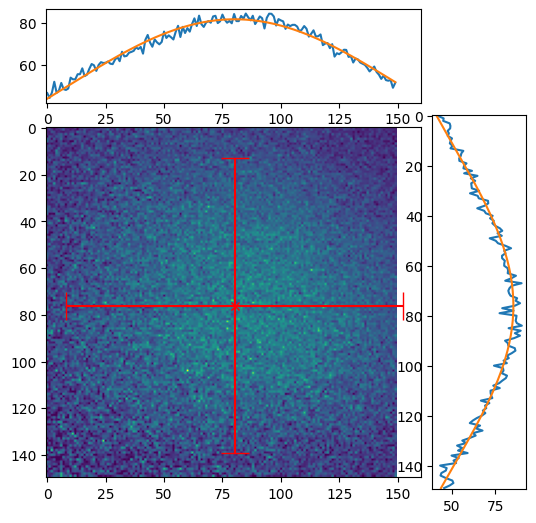

In [86]:
dr.plot_fit()

In [40]:
dr.y

array([40.31655133, 35.88829791, 38.82916334, 42.18626998, 42.4626217 ,
       38.20560147, 43.55569698, 39.17744364, 40.35395076, 43.57293484,
       41.42793416, 43.70666191, 41.263493  , 36.12052392, 39.96484411,
       43.72989083, 43.06816383, 38.48328665, 39.2713335 , 46.5551364 ,
       41.29233329, 39.66019434, 43.02087217, 41.25732647, 41.75574466,
       47.07627754, 41.65916   , 46.55385636, 44.48825134, 46.74717161,
       44.27612286, 45.49772653, 43.63099148, 44.25018782, 45.37991329,
       45.75066868, 44.4771555 , 49.67199941, 49.00808654, 45.20687353,
       49.03501441, 49.30563927, 47.69536208, 48.53992561, 45.46543111,
       45.70185235, 49.61456111, 45.22918161, 47.7962065 , 51.33543819,
       44.55461868, 48.51364203, 46.89248156, 48.67639715, 52.48624653,
       46.07296037, 50.63628591, 53.48980406, 41.51345847, 50.90115686,
       43.14658299, 49.09383057, 49.48334821, 47.92709086, 47.27463289,
       51.7085292 , 46.78655998, 53.00166431, 50.38865672, 50.03

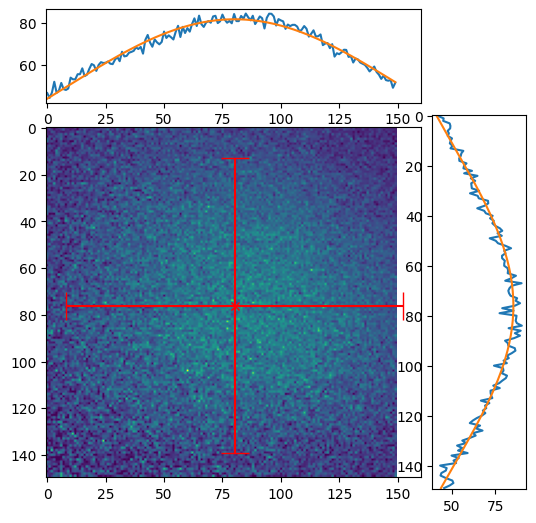

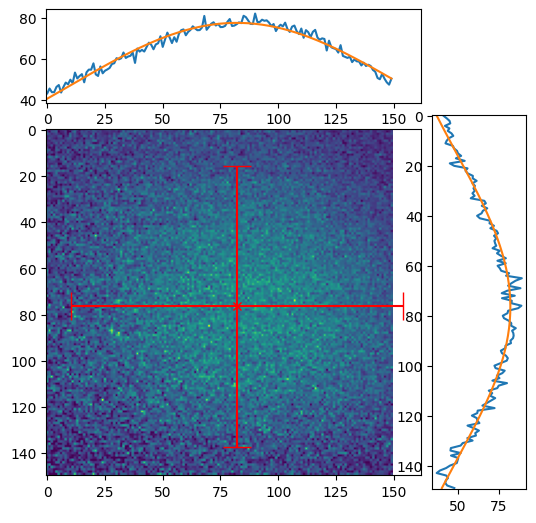

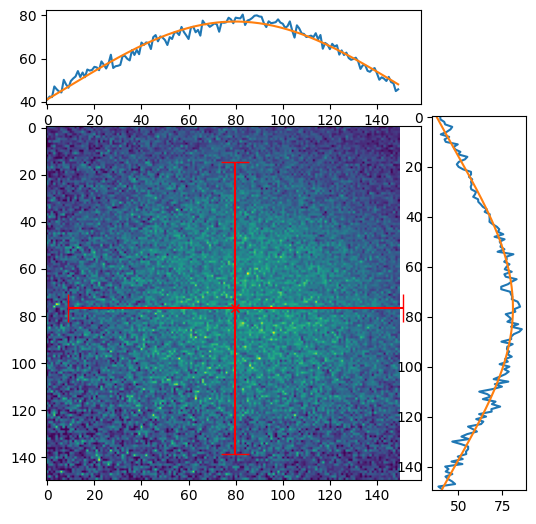

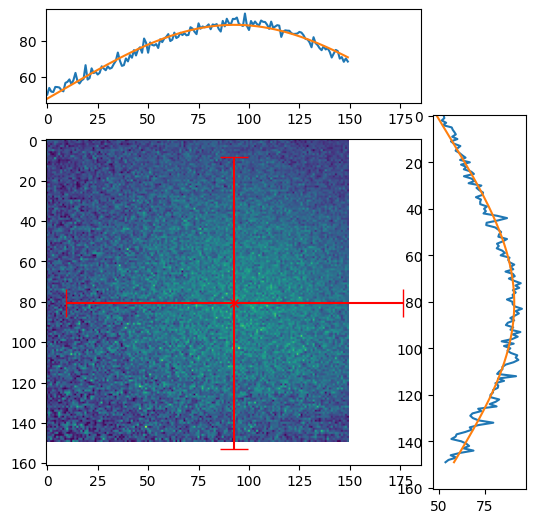

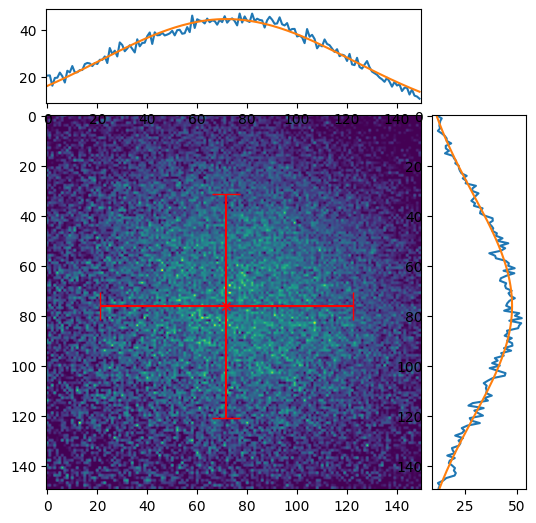

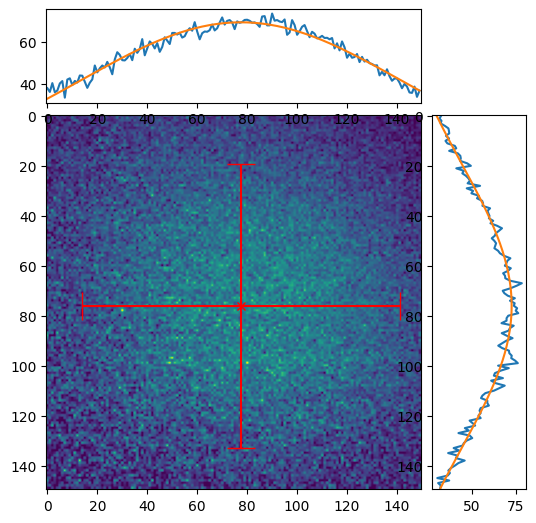

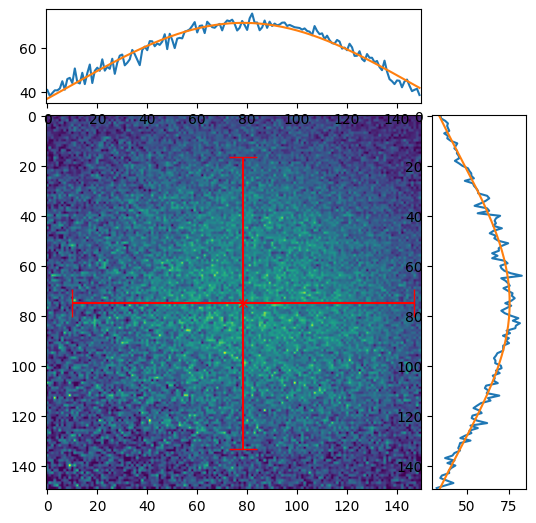

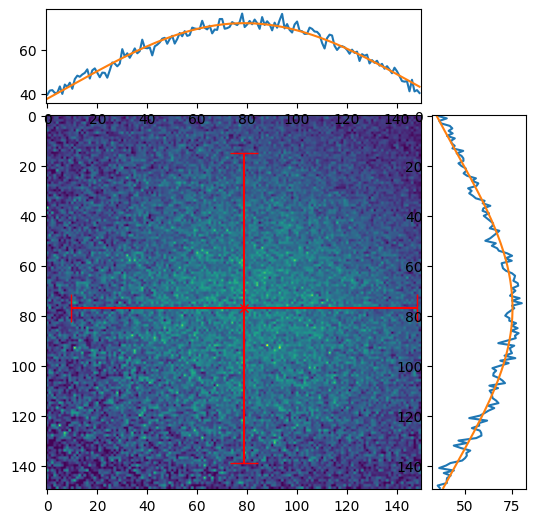

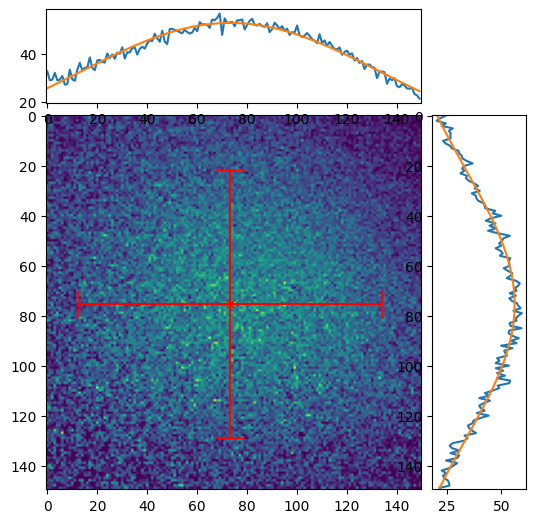

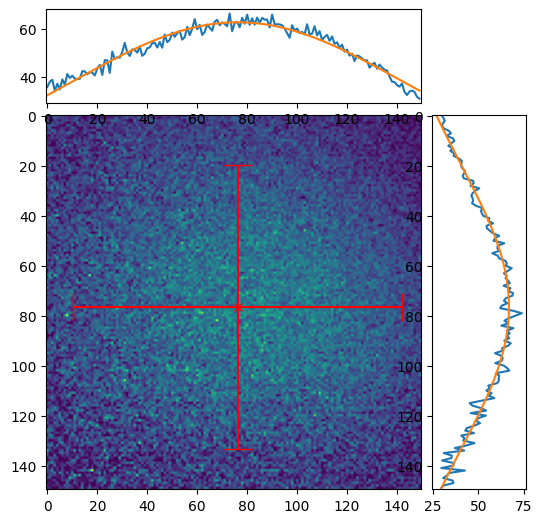

In [98]:
for i in range(10):
    data[1+10*i].plot_fit()

In [81]:
class DataRun:
    def __init__(self, num, time):
        self.num = num
        self.time = time

        self.images()
        self.load()
        self.mask(.25)
        #extract blob rectangle from image
        self.blob_image = self.od_arr[round(self.cy)-75:round(self.cy)+75, round(self.cx)-75:round(self.cx)+75]
        #apply a median filter
        self.fit()

    def incircle(self, center, radius, pt):
            return (pt[0]-center[0])**2 + (pt[1]-center[1])**2 < radius**2

    def images(self):
        images =  [imread(DATA_DIR / f"image_{self.num}_{i}.tif") for i in range(4)]

        im0 = images[0]
        im0_background = images[2]
        im1 = images[1]
        im1_background = images[3]

        I0_arr=np.subtract(np.array(im0),
                            np.array(im0_background)).astype(int)
        I_arr=np.subtract(np.array(im1),
                            np.array(im1_background)).astype(int)

        return I_arr, I0_arr

    def grow_box(self,box, factor):
        width = box[3]-box[1]
        height = box[2]-box[0]
        x1 = round(box[1] - width*factor)
        y1 = round(box[0] - height*factor)
        x2 = round(box[3] + width*factor)
        y2 = round(box[2] + height*factor)
        return (x1,y1,x2,y2)

    def load(self):

        I_arr, I0_arr = self.images()

        I_div_arr = np.divide(I_arr, I0_arr)
        od_arr = np.log(I_div_arr)

        #first pass, just clip anything not within the aperture
        for i,row in enumerate(od_arr):
            for j, pixel in enumerate(row):
                if pixel < 0 or not self.incircle((605,620),150,(i,j)):
                    od_arr[i][j] = 0

        self.od_arr = od_arr

    def mask(self, threshhold):
        value_mask = self.od_arr[:,:] > threshhold
        self.mask_filtered = median_filter(value_mask, 50)

        blobs = label(self.mask_filtered)
        props = regionprops(blobs) #generate a properties dictionary

        if not props:
            return 0

        self.cy, self.cx = props[0].centroid

        return props[0].num_pixels

    def gaussian_fit(self, x, A, mu, sigma):
        return A*np.exp(-(x-mu)**2/(2*sigma**2))
    
    def fit(self):
        #compute marginals and fit to a gaussian

        x, y = margins(self.blob_image)
        x = x.T[0]
        y = y[0]

        x[x == np.inf] = 0
        y[y == np.inf] = 0

        self.popt_x, self.pcov_x = curve_fit(self.gaussian_fit, np.arange(len(x)), x, p0 =[350, 150, 60])
        self.popt_y, self.pcov_y = curve_fit(self.gaussian_fit, np.arange(len(y)), y, [350,150,60])

        self.x = x
        self.y = y

    def plot_box(self):
        #draw bounding box
        fig, ax = plt.subplots()
        rect = plt.Rectangle((self.box[0], self.box[1]), self.box[2]-self.box[0], self.box[3]-self.box[1])
        rect.set(fill=False, color = "red")
        ax.add_artist(rect)
        ax.imshow(self.od_arr)

    def plot_blob(self):
        plt.imshow(self.mask_filtered)

    def plot_fit(self):

        fig = plt.figure(figsize=(6,6))
        gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                            left=0.1, right=0.9, bottom=0.1, top=0.9,
                            wspace=0.05, hspace=0.05)
        ax = fig.add_subplot(gs[1,0])
        ax.imshow(self.blob_image)

        #axes are flipped!!
        ax_y = fig.add_subplot(gs[0,0], sharex=ax)
        ax_x = fig.add_subplot(gs[1,1], sharey=ax)

        ax_y.plot(self.y)
        ax_y.plot(np.arange(len(self.y)), self.gaussian_fit(np.arange(len(self.y)),*self.popt_y))

        ax_x.plot(self.x, np.arange(len(self.x)))
        ax_x.plot(self.gaussian_fit(np.arange(len(self.x)),*self.popt_x),np.arange(len(self.x)))

        ax.errorbar(self.popt_y[1], self.popt_x[1], xerr = np.abs(self.popt_y[2]), yerr = np.abs(self.popt_x[2]), color = 'r', marker = "x", capsize = 10)

In [4]:
import pickle
with open("data.pickle", "rb") as f:
    data = pickle.load(f)

In [165]:
sigma_times = {time :   [] for time in np.arange(.1, 1.1, .1)}
for datum in data:
    sigma_times[datum.time].append(np.abs(datum.popt_x[2]))

In [166]:
errs = [np.std(sigma_times[i]) for i in sigma_times.keys()]
means = [np.mean(sigma_times[i]) for i in sigma_times.keys()]

In [167]:
fit = lambda t, a, b : a*t**2+b
popt, pcov = curve_fit(fit, np.arange(.1, 1.1, .1), means, sigma = errs)

Text(0, 0.5, '$\\sigma$ (px)')

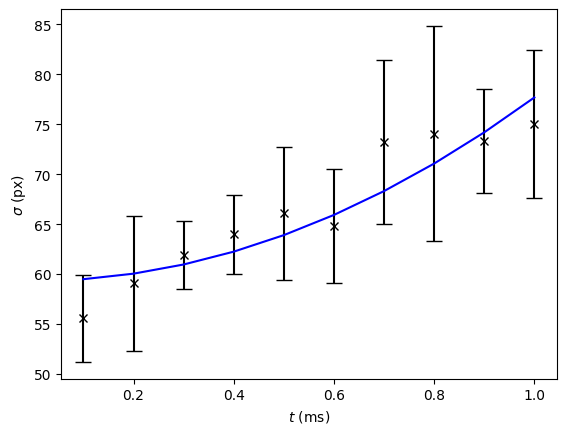

In [169]:
plt.errorbar(np.arange(.1, 1.1, .1),means, yerr = errs, c= "k", capsize = 6, linestyle = "None", marker = "x")
plt.plot(np.arange(.1, 1.1, .1),fit(np.arange(.1, 1.1, .1), *popt), c = "b")
plt.xlabel(r"$t$ (ms)")
plt.ylabel(r"$\sigma$ (px)")

In [164]:
np.sqrt(popt[0])

4.175350864314167